**
Mik van der Drift (s4804236)  
Melle Starke (s4792696)
**

# Chapter 6
## Deep learning


    Hand-in bug-free (try "Kernel" > "Restart & Run All") and including all (textual as well as figural) output via Blackboard before the deadline (see Blackboard).

Learning goals:
1. Get familiar with a state-of-the-art framework for deep learning
1. Implement and run a convolutional neural network
1. See what convolution does

In [1]:
% matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import chainer
from chainer import cuda, Function, gradient_check, report, training, utils, Variable
from chainer import datasets, iterators, optimizers, serializers
from chainer import Link, Chain, ChainList
import chainer.functions as F
import chainer.links as L
from chainer.training import extensions
import os, json
import scipy.signal as ss

In [2]:
mlp_output_folder = "chainermlp/"
cnn_output_folder = "chainercnn/"

def get_losses(output_folder):

    with open(os.path.join(output_folder, "log")) as data_file:
        data = json.load(data_file)

    training_loss = map(lambda x: x["main/loss"], data)
    validation_loss = map(lambda x: x["validation/main/loss"], data)
    
    return training_loss, validation_loss

When working on a state-of-the-art neural network project you would rely on one of the various neural network frameworks that are available, instead of implementing core functionality by yourself. In this exercise you will work on implementing an MLP and a convolutional neural network in the Chainer framework. At the moment we use this framework for most of the work in our group as it is flexible and has quite intuitive and pythonic syntax.  

Due to the popularity of deep learning various [Neural Network Frameworks](http://chainer.readthedocs.io/en/latest/comparison.html) exist, and it is unclear whether one of them will "win". Among those mentioned, Chainer and PyTorch (which is quite popular right now) have very similar syntax, and in fact PyTorch started as a fork from Chainer, reimplementing core functionality such as autograd in C++. This makes it faster, but less versatile. Google is developing and promoting the TensorFlow framework, which is fast for statically defined neural network flows. 


In this assignment you will follow a Chainer tutorial for implementing a standard multi-layer perceptron and a convolutional neural network. You will first copy the tutorial code and then make several adaptations. For a few steps you should consult the documentation or example code to check out how to implement them. 

### Exercise 1 (3 points)

Read the tutorial at https://docs.chainer.org/en/stable/tutorial/basic.html. As you go along, transfer the code for the Multi-Layer Perceptron example on MNIST into the notebook (and try running it). Use the variant that makes use of the Trainer framework, i.e. you do not need to handle the gradients yourself. 

Change the MLP training code so that it is similar to the MLP we implemented in the MLP exercise, i.e. it should use: 

1. A single hidden layer of 16 units (that is, two weight layers)
1. ReLU activation function
1. Stochastic Gradient Descent with a learning rate of 0.001 as optimizer
1. Training should do 50 iterations over the training set

For **evaluating the model**, set up the `trainer` object as follows: 
1. When initializing the `trainer` object, set the output folder to be `mlp_output_folder`.
1. Extend your `trainer` object with an `Evaluator` object that evaluates your `model` on the test set. 
1. Extend your `trainer` object with the `LogReport()` object. 
1. For printing the current model performance underneath the cell, extend the `trainer` object with a `PrintReport` object. Use the keys `"epoch"`, `"main/accuracy"`, `"validation/main/accuracy"`,  `"main/loss"` and `"validation/main/loss"`.
1. For plotting the accuracy and losses over epochs, extend the `trainer` object with a `PlotReport` object. Use the same keys as for `PrintReport` except `"epoch"`. Set the file name to `mlp_plot.png`.

Embed the generated `mlp_plot.png` underneath your code via `<img src='chainermlp/mlp_plot.png'>`. **Please additionally attach `mlp_plot.png` to your submission.**

In [3]:
# Load the MNIST data set as 784-length vectors (default): 
train, test = datasets.get_mnist()
print("Shape of a single example:", train[0][0].shape)

('Shape of a single example:', (784L,))


### Solution 1

In [4]:
# Your MLP, including output
class MLP(Chain):
    def __init__(self, n_units, n_out):
        super(MLP, self).__init__()
        with self.init_scope():
            self.l1 = L.Linear(None, n_units)
            self.l2 = L.Linear(None, n_out)

    def __call__(self, x):
        h1 = F.relu(self.l1(x))
        y = self.l2(h1)
        return y
    
class Classifier(Chain):
    def __init__(self, predictor):
        super(Classifier, self).__init__()
        with self.init_scope():
            self.predictor = predictor

    def __call__(self, x, t):
        y = self.predictor(x)
        loss = F.softmax_cross_entropy(y, t)
        accuracy = F.accuracy(y, t)
        report({'loss': loss, 'accuracy': accuracy}, self)
        return loss
    
train_iter = iterators.SerialIterator(train, batch_size=100, shuffle=True)
test_iter = iterators.SerialIterator(test, batch_size=100, repeat=False, shuffle=False)

model = L.Classifier(MLP(16, 16))
optimizer = optimizers.SGD(lr=0.001)
optimizer.setup(model)

updater = training.StandardUpdater(train_iter, optimizer)
trainer = training.Trainer(updater, (50, 'epoch'), out='mlp_output_folder')

trainer.extend(extensions.Evaluator(test_iter, model))
trainer.extend(extensions.LogReport())
trainer.extend(extensions.PrintReport(['epoch', 'main/accuracy', 'validation/main/accuracy']))
trainer.extend(extensions.PlotReport(['main/loss', 'validation/main/loss'], file_name='mlp_plot.png'))

trainer.run()

epoch       main/accuracy  validation/main/accuracy
1           0.253          0.3807                    
2           0.4667         0.545                     
3           0.617833       0.6799                    
4           0.722267       0.7577                    
5           0.771433       0.7916                    
6           0.795383       0.806                     
7           0.810067       0.8219                    
8           0.820817       0.831                     
9           0.829233       0.8402                    
10          0.836217       0.8458                    
11          0.842483       0.8521                    
12          0.847933       0.8566                    
13          0.85195        0.8606                    
14          0.85605        0.8634                    
15          0.859517       0.8665                    
16          0.862583       0.8684                    
17          0.86515        0.8711                    
18          0.867967       0.8

Embed `mlp_plot.png`: 
<img src='mlp_output_folder/mlp_plot.png'>

### Exercise 2  (0.5 points)

The input layer weights that the MLP has learned can be found in `model.predictor.l1.W.data`. Plot them below (as we did in the MLP and autoencoder exercises). 

### Solution 2

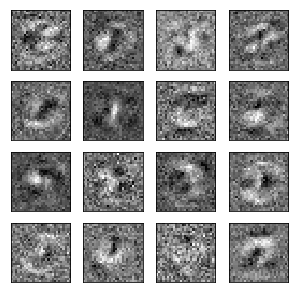

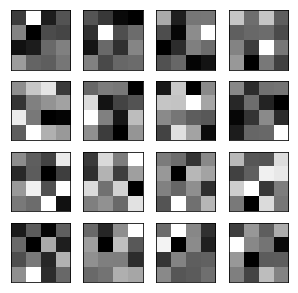

In [7]:
# Plot the weights
w1_hidden = model.predictor.l1.W.data.shape[0]
w2_hidden = model.predictor.l2.W.data.T.shape[0]

plt.figure(figsize=([5, 5]))
for i in range(w1_hidden):
        plt.subplot(4, 4, i + 1)
        fig = plt.imshow(model.predictor.l1.W.data[i, :].reshape([28, 28]), cmap = 'gray')
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)

plt.figure(figsize=([5, 5]))
for i in range(w2_hidden):
        plt.subplot(4, 4, i + 1)
        fig = plt.imshow(model.predictor.l2.W.data.T[:, i].reshape([4, 4]), cmap = 'gray')
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)

### Exercise 3: Convolution with hand-made kernels (1 point)
In convolutional neural networks we use a mathematical operator between two functions $f$ and $g$ called [*convolution*](https://en.wikipedia.org/wiki/Convolution). In terms of images, one could intuitively think of $f$ as an image, and $g$ as a filter kernel (i.e., a receptive field). For images we need to use 2D convolution: 

$$f(x, y) \ast g(x, y) = \sum^N_{i=-N}\sum^N_{j=-N} f(x, y)g(x-i, y-j)$$

Intuitively, the kernel $g$ is applied on all spatial locations of $f$. You could think of $g$ as having weights that represent how it singles out local input. Usually there are various of these filter kernels $g$, scanning the image for many possible features. 

In this exercise you will perform a simple convolution on an image. We first choose an image: 

[]

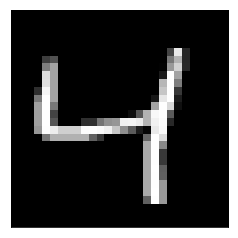

In [6]:
image = train[2][0].reshape((28, 28))

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.imshow(image, cmap="gray")
ax.set_xticks([], []) ; ax.set_yticks([], [])

1. Make four $3 \times 3$ kernels. They should represent horizontal, vertical, and the two diagonal line feature detectors.
1. Plot these kernels.
1. Apply the kernels to the image, e.g. by using `convolved2d` from `scipy`.
1. Plot the resulting feature activity map for each of the kernels. 

### Solution 3

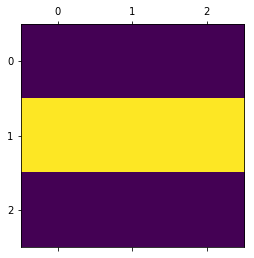

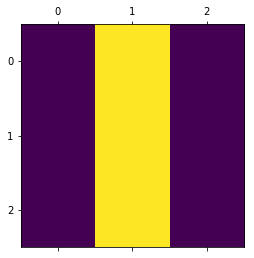

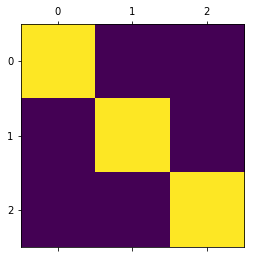

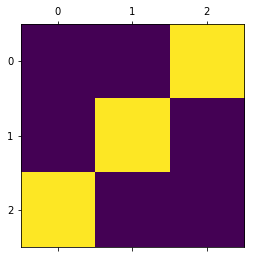

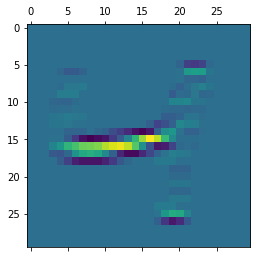

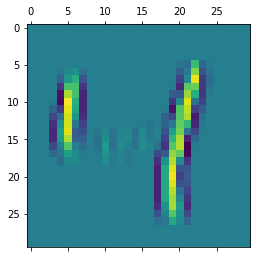

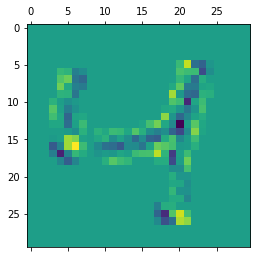

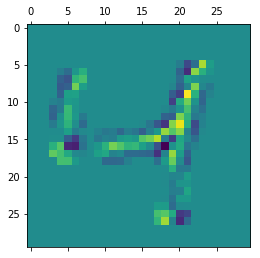

In [8]:
# 1. Create kernels
kernel_hor = [[-1.0, -1.0, -1.0], 
              [2.0,   2.0,  2.0], 
              [-1.0, -1.0, -1.0]]
    
kernel_vert = [[-1.0, 2.0, -1.0], 
               [-1.0, 2.0, -1.0], 
               [-1.0, 2.0, -1.0]]

kernel_dia_tl = [[2.0, -1.0, -1.0], 
                 [-1.0, 2.0, -1.0], 
                 [-1.0, -1.0, 2.0]]

kernel_dia_tr = [[-1.0, -1.0, 2.0], 
                 [-1.0, 2.0, -1.0], 
                 [2.0, -1.0, -1.0]]


# 2. Plot kernels
plt.matshow(kernel_hor)
plt.matshow(kernel_vert)
plt.matshow(kernel_dia_tl)
plt.matshow(kernel_dia_tr)

# 3. Convolve the image with the kernels
grad_hor = ss.convolve2d(image, kernel_hor)
grad_vert = ss.convolve2d(image, kernel_vert)
grad_dia_tl = ss.convolve2d(image, kernel_dia_tl)
grad_dia_tr = ss.convolve2d(image, kernel_dia_tr)

# 4. Plot the activity maps
plt.matshow(grad_hor)
plt.matshow(grad_vert)
plt.matshow(grad_dia_tl)
plt.matshow(grad_dia_tr)


### Exercise 4 (3 points)

We want to train a convolutional neural network (CNN) next. Check [this project](https://github.com/vdumoulin/conv_arithmetic) to get intuition for the operations in convolutional neural network layers. 


1. Create `class CNN(Chain)` that should contain the new model. It will be similar to the `MLP` class, so you can start by copying the code of the MLP model class. 
1. The network should have one [2D-convolutional layer](https://docs.chainer.org/en/stable/reference/links.html). The first layer `conv1` should have 4x4 kernels, a stride of 1 and 10 output channels. As in the MLP, a second `Linear` layer should connect with the output units. 
1. Use ReLU activation functions on the convolutional layer activation.
1. Add 2D max-pooling with a `(2,2)` pooling window after the convolutional layer. 
1. Copy the rest of the training code underneath and adapt it so that it uses your `CNN` model. Change the plot file name to `cnn_plot.png`. Run the model for 30 full iterations through the training set and embed `cnn_plot.png` as before. The output directory should be `cnn_output_folder` now. **Please additionally attach `cnn_plot.png` to your submission.**

This will take a while to run. You can test the code by reducing the number of output channels of `conv1` first.  Usually you would train ConvNets on GPUs, which implement many of the linear algebra operations that are used here much more efficiently. 

In [9]:
# Load the MNIST data set in shape 1x28x28-length (the 2D shape is necessary for the convolutional layer): 
train, test = datasets.get_mnist(ndim=3)
print "Shape of a single example:", train[0][0].shape

Shape of a single example: (1L, 28L, 28L)


### Solution 4

In [10]:
# Your CNN, including output
class CNN(Chain):
    def __init__(self, n_units, n_out):
        super(CNN, self).__init__()
        with self.init_scope():
            self.conv1 = L.Convolution2D(in_channels = None, out_channels = n_out, ksize = 4, stride = 1)
            self.l2 = L.Linear(None, n_out)

    def __call__(self, x):
        h1_relu = F.relu(self.conv1(x))
        h1 = F.max_pooling_2d(h1_relu, 2)
        y = self.l2(h1)
        return y
    
class Classifier(Chain):
    def __init__(self, predictor):
        super(Classifier, self).__init__()
        with self.init_scope():
            self.predictor = predictor

    def __call__(self, x, t):
        y = self.predictor(x)
        loss = F.softmax_cross_entropy(y, t)
        accuracy = F.accuracy(y, t)
        report({'loss': loss, 'accuracy': accuracy}, self)
        return loss
    
train_iter = iterators.SerialIterator(train, batch_size=100, shuffle=True)
test_iter = iterators.SerialIterator(test, batch_size=100, repeat=False, shuffle=False)

model = L.Classifier(CNN(4, 10))
optimizer = optimizers.SGD(lr=0.001)
optimizer.setup(model)

updater = training.StandardUpdater(train_iter, optimizer)
trainer = training.Trainer(updater, (30, 'epoch'), out='cnn_output_folder')

trainer.extend(extensions.Evaluator(test_iter, model))
trainer.extend(extensions.LogReport())
trainer.extend(extensions.PrintReport(['epoch', 'main/accuracy', 'validation/main/accuracy']))
trainer.extend(extensions.PlotReport(['main/loss', 'validation/main/loss'], file_name='cnn_plot.png'))

trainer.run()

epoch       main/accuracy  validation/main/accuracy
1           0.59835        0.8017                    
2           0.8236         0.8533                    
3           0.852917       0.8745                    
4           0.868217       0.8837                    
5           0.876767       0.8899                    
6           0.882317       0.8954                    
7           0.887017       0.8998                    
8           0.891217       0.9022                    
9           0.8943         0.9052                    
10          0.896833       0.9071                    
11          0.8986         0.9092                    
12          0.9004         0.9112                    
13          0.902133       0.9117                    
14          0.903633       0.9117                    
15          0.90465        0.9141                    
16          0.906367       0.9154                    
17          0.907217       0.9155                    
18          0.908317       0.9

Embed `cnn_plot.png`:
<img src='cnn_output_folder/cnn_plot.png'>

### Exercise 5 (0.5 points)
The input layer weights that the ConvNet has learned can be found in `model.predictor.conv1.W.data`. Plot them below (as we did in the MLP and autoencoder exercises).

### Solution 5

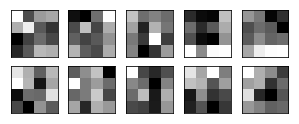

In [10]:
# Plot the weights
w1_hidden = model.predictor.conv1.W.data.shape[0]

plt.figure(figsize=([5,5]))
for i in range(w1_hidden):
        plt.subplot(5, 5, i + 1)
        fig = plt.imshow(model.predictor.conv1.W.data[i, :].reshape([4, 4]), cmap = 'gray')
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)

### Exercise 6 (2 points)
1. Which of the two models performed better for classifying MNIST digits in this example? Compare speed of training and test set accuracy. 

1. The main difference of the models is the type of the first layer. What leads to the success of the first layer of the better-performing model? 

1. Explain ways in which the convolution operation and the resulting feature maps are biologically plausible (1 way) and biologically implausible (1 way). 

### Solution 6
1. The first model completed a training run much faster than the second one. But accuracy wise the second model is vastly superior, achieving an entropy loss of 0.4 after 5000 iterations, compared to the first model that only got close to 0.4 after 30000 iterations.
1. Using convolution, a weight layer can be updated more accurately. This is done by taking the weights as a result of both the image and the receptive field. This results in a more accurate representation but also in more computational load.
1. I don't understand the concept of convolution well enough to be able to answer that question.

You can play around further with your code for this assignment by replacing the MNIST dataset with a more interesting / difficult to solve data set. For instance, you could use: 

`chainer.datasets.get_cifar10()`  ([CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) - photos of 10 natural object classes)

and 

`chainer.datasets.get_svhn()`  ([SVHN](http://ufldl.stanford.edu/housenumbers/) - house numbers from Google StreetView)